In [146]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  []


In [147]:
(train_ds, val_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds, ds_info)

In [148]:
# gets in a dataset and returns target values
def prepare_data(dataset, batch_size, noise_variance):
    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, targets: (tf.cast(img, tf.float32), targets))

    # convert image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, targets: ((img/128.)-1., targets))

    # replace targets with initial img, replace initial img with img+noise
    dataset = dataset.map(lambda img, target: (img + tf.random.normal(img.shape, mean=0, stddev=noise_variance), img))

    # clip min value to -1 and max value to +1
    dataset = dataset.map(lambda img, target: (tf.clip_by_value(img, clip_value_min=-1, clip_value_max=1), target))

    dataset = dataset.cache()
    dataset = dataset.shuffle(4096)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [149]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Encoder, self).__init__()
  
        self.my_layers = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(64, activation='relu')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [150]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Decoder, self).__init__()

        self.my_layers = [tf.keras.layers.Dense(14 * 14, activation='relu'),
                          tf.keras.layers.Reshape((14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [151]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()


    @tf.function
    def call(self, x, training=False):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [152]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 10
batch_size = 64
noise_variance = 0.5

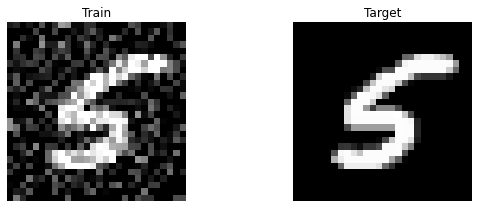

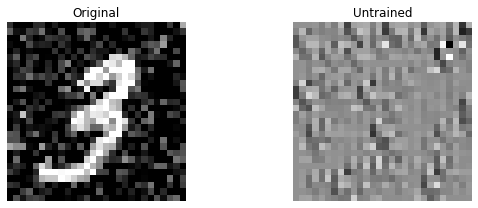

In [153]:
model = Autoencoder()

train_dataset = prepare_data(train_ds, batch_size, noise_variance)
val_dataset = prepare_data(val_ds, batch_size, noise_variance)

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Train')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Target')
    plt.axis('off')
    plt.imshow(label[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Untrained')
    plt.axis('off')
    plt.imshow(model(img)[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

In [154]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error'
              )

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=batch_size,
                    epochs=15)

model.summary()

Epoch 1/15
938/938 [==============================] - 55s 58ms/step - loss: 0.9679 - val_loss: 0.8726
Epoch 2/15
938/938 [==============================] - 56s 59ms/step - loss: 0.8680 - val_loss: 0.8635
Epoch 3/15
938/938 [==============================] - 56s 59ms/step - loss: 0.8647 - val_loss: 0.8620
Epoch 4/15
938/938 [==============================] - 58s 62ms/step - loss: 0.8632 - val_loss: 0.8615
Epoch 5/15
938/938 [==============================] - 56s 60ms/step - loss: 0.8622 - val_loss: 0.8597
Epoch 6/15
938/938 [==============================] - 56s 60ms/step - loss: 0.8614 - val_loss: 0.8591
Epoch 7/15
938/938 [==============================] - 56s 60ms/step - loss: 0.8608 - val_loss: 0.8589
Epoch 8/15
938/938 [==============================] - 55s 59ms/step - loss: 0.8601 - val_loss: 0.8602
Epoch 9/15
938/938 [==============================] - 55s 59ms/step - loss: 0.8595 - val_loss: 0.8573
Epoch 10/15
938/938 [==============================] - 56s 60ms/step - loss: 0.859

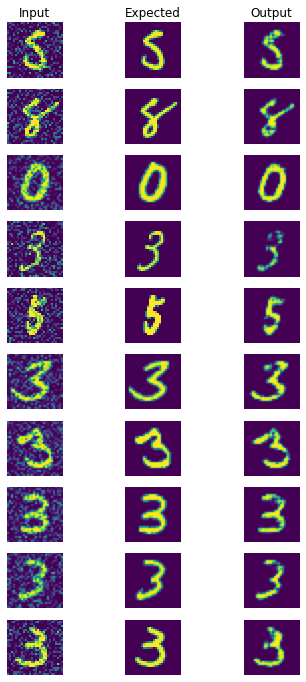

In [155]:
# Plot example images
figure = plt.figure(figsize=(6, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  if i < 4:
    plt.title(name)

i = 1
for imgs, targets in val_dataset.shuffle(4096).take(rows):
  output = model(imgs[0].reshape((1, 28, 28, 1)))
  
  show_image(imgs[0], i, 'Input')
  i += 1

  show_image(targets[0], i, 'Expected')
  i += 1

  show_image(output, i, 'Output')
  i += 1


In [176]:
from sklearn.manifold import TSNE
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

color_dict = {0: "black",
              1: "green",
              2: "red",
              3: "yellow",
              4: "pink",
              5: "blue",
              6: "orange",
              7: "purple",
              8: "cyan",
              9: "grey",
              }


plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range


for old, new in zip(train_ds.take(200), train_dataset.take(200)):
    _, label = old
    imgs, imgs_label = new 

    output = model.encoder(imgs[0].reshape((1, 28, 28, 1))).reshape(-1, 1)

    output_embedded = TSNE(n_components=2).fit_transform(output)

    x = output_embedded[:, 0]
    y = output_embedded[:, 1]

    #x = scale_to_01_range(x)
    #y = scale_to_01_range(y)
    plt.plot(x, y, 'o', color=color_dict[label.numpy()])


The points of the specific labels always follow a pattern. However the points arent clustered according to their labels, they much more overlap.
We expected a pattern in which the different labels are clustered based on their labels and not to follow a pattern.


In [172]:

from scipy import interpolate

figure = plt.figure(figsize=(6, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  if i < 4:
    plt.title(name)

i = 1

for img, target in val_dataset.shuffle(4096).take(rows):
    img_1, target_1 = img, target


for img, target in val_dataset.shuffle(4096).take(rows):
    img_2, target_2 = img, target

embedded_1 = model.encoder(img_1[0].reshape((1, 28, 28, 1)))
embedded_2 = model.encoder(img_2[0].reshape((1, 28, 28, 1)))

interpol = interpolate.interp1d(embedded_1.numpy()[0], embedded_2.numpy()[0], kind='linear')

minima = min(np.min(embedded_1[0]), np.min(embedded_2[0])).numpy()
maxima = max(np.max(embedded_1[0]), np.max(embedded_2[0])).numpy()
steps = np.linspace(minima, maxima, 14*14)

embedded_new = interpol(steps)
embedded_new = tf.convert_to_tensor(embedded_new)
embedded_new = tf.expand_dims(embedded_new, -1)

print(embedded_new)
output_new = model.decoder(embedded_new)
print(output_new)
  
"""show_image(img_1[0], i, 'first img')
i += 1

show_image(img_2[0], i, 'second img')
i += 1

show_image(output, i, 'interpolation')
i += 1"""

tf.Tensor(
[[        nan]
 [ 1.44586727]
 [ 2.89173455]
 [ 4.33760182]
 [ 5.7834691 ]
 [ 7.22933637]
 [ 8.67520365]
 [10.12107092]
 [11.5669382 ]
 [13.01280547]
 [14.45867275]
 [15.90454002]
 [17.35040729]
 [18.79627457]
 [20.24214184]
 [28.69706534]
 [17.33648665]
 [10.58951513]
 [12.77488367]
 [14.96025221]
 [17.14562074]
 [19.33098928]
 [21.51635782]
 [23.70172636]
 [25.8870949 ]
 [28.07246343]
 [30.25783197]
 [32.44320051]
 [34.66864852]
 [36.9163943 ]
 [39.16414007]
 [41.41188585]
 [43.65963163]
 [41.83808644]
 [37.74022575]
 [33.64236505]
 [29.54450435]
 [25.44664366]
 [21.34878296]
 [17.25092227]
 [13.15306157]
 [12.15631404]
 [ 4.3759167 ]
 [ 9.07966074]
 [13.78340477]
 [18.48714881]
 [27.67514612]
 [33.65902387]
 [24.63774813]
 [24.88351354]
 [25.12927895]
 [25.37504436]
 [25.62080976]
 [25.86657517]
 [26.11234058]
 [26.35810598]
 [26.60387139]
 [26.98611809]
 [42.10093432]
 [45.16847564]
 [48.23601697]
 [51.3035583 ]
 [54.37109963]
 [57.43864096]
 [60.50618228]
 [63.57372361]

ValueError: Exception encountered when calling layer "decoder_2" (type Decoder).

in user code:

    File "C:\Users\JULIAN~1\AppData\Local\Temp/ipykernel_10192/3469720741.py", line 16, in call  *
        x = layer(x)
    File "c:\Users\Julian Unland\anaconda3\envs\ki_uebungen\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Julian Unland\anaconda3\envs\ki_uebungen\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 64, but received input with shape (196, 1)


Call arguments received by layer "decoder_2" (type Decoder):
  • x=tf.Tensor(shape=(196, 1), dtype=float32)
  • training=False

<Figure size 432x864 with 0 Axes>